In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Galaxy Color Distribution

In [5]:
from astropy.table import Table
t_1 = Table.read('../data/sample_1_g_minus_r.dat', format='ascii')
t_2 = Table.read('../data/sample_2_g_minus_r.dat', format='ascii')
t_3 = Table.read('../data/sample_3_g_minus_r.dat', format='ascii')
t_4 = Table.read('../data/sample_4_g_minus_r.dat', format='ascii')
t_5 = Table.read('../data/sample_5_g_minus_r.dat', format='ascii')
t_6 = Table.read('../data/sample_6_g_minus_r.dat', format='ascii')
t_7 = Table.read('../data/sample_7_g_minus_r.dat', format='ascii')
t_8 = Table.read('../data/sample_8_g_minus_r.dat', format='ascii')
t_9 = Table.read('../data/sample_9_g_minus_r.dat', format='ascii')
t_10 = Table.read('../data/sample_10_g_minus_r.dat', format='ascii')
t_11 = Table.read('../data/sample_11_g_minus_r.dat', format='ascii')
t_12 = Table.read('../data/sample_12_g_minus_r.dat', format='ascii')
t_13 = Table.read('../data/sample_13_g_minus_r.dat', format='ascii')
t_14 = Table.read('../data/sample_14_g_minus_r.dat', format='ascii')
t_15 = Table.read('../data/sample_15_g_minus_r.dat', format='ascii')

# magnitude bins
mag_bins = np.arange(-24, -16.99, 0.25)[::-1]
mag_bin_centers = (mag_bins[:-1]+mag_bins[1:])/2.0
N_mag_bins = len(mag_bins)-1

print("number of magnitude bins: ", N_mag_bins)

# color bins
color_bins = np.arange(0,1.5001,0.05)
color_bin_centers = (color_bins[:-1]+color_bins[1:])/2.0

number of magnitude bins:  28


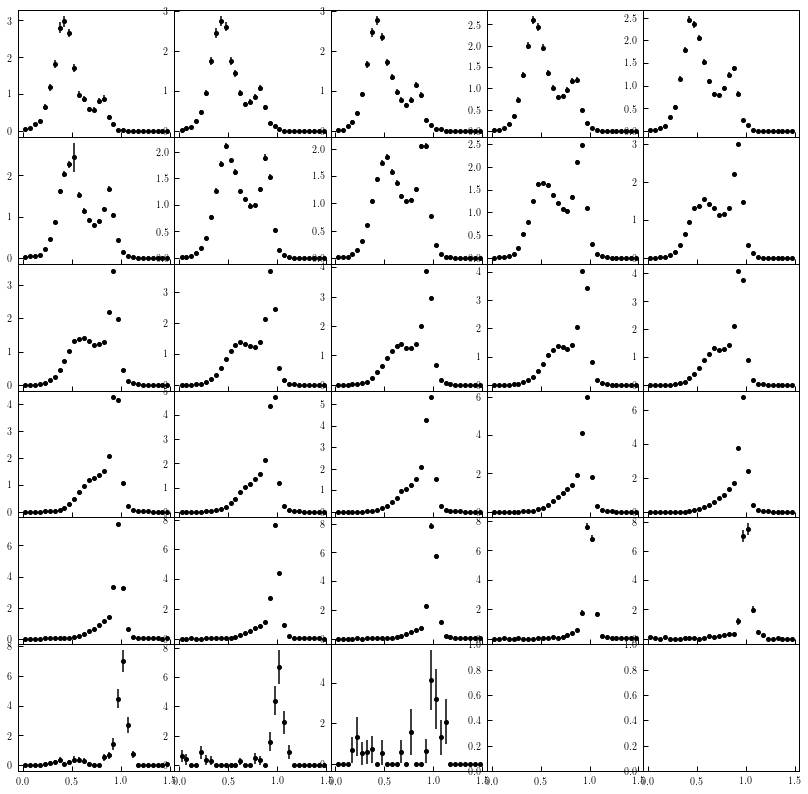

In [6]:
# row and column sharing
fig, axes = plt.subplots(6, 5, sharex=True, sharey=False, figsize=(14.0,14.0))
axes = axes.flatten()
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(0,28):
    
    ax = axes[i]
    
    t = Table.read('../data/sample_'+str(int(i))+'_g_minus_r.dat', format='ascii')
    
    x0 = t['g_minus_r']
    y0 = t['frequency']
    y0_err = t['err']
    ax.errorbar(x0,y0,y0_err,fmt='o', ms=4, color='black')
    
plt.show()

(-17, -24)

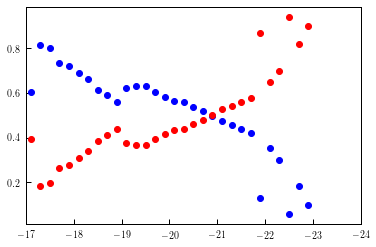

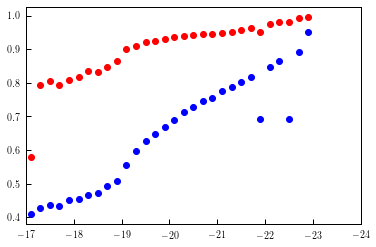

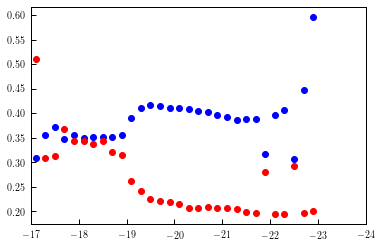

In [20]:
plt.figure()
plt.plot(mag_bin_centers, fs, 'o', color='blue')
plt.plot(mag_bin_centers, 1-fs, 'o', color='red')
plt.xlim([-17,-24])

plt.figure()
plt.plot(mag_bin_centers, m1s, 'o', color='blue')
plt.plot(mag_bin_centers, m2s, 'o', color='red')
plt.xlim([-17,-24])

plt.figure()
plt.plot(mag_bin_centers, s1s, 'o', color='blue')
plt.plot(mag_bin_centers, s2s, 'o', color='red')
plt.xlim([-17,-24])

In [21]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
gmm = GaussianMixture(n_components=3, covariance_type='spherical',tol=10**-4,
                      means_init=[[0.4],[0.7],[0.9]], weights_init=[0.45,0.1,0.45],
                      precisions_init=[1.0/0.4**2, 1.0/0.3**2, 1.0/0.2**2])

In [22]:
color_model = GalaxyColor()
color_model.params['m1'] = -0.1134652255388035
color_model.params['b1'] = -1.5754936392946468
color_model.params['m2'] = -0.033475839944698944
color_model.params['b2'] = 0.24608502181357306

0 1767 True
1 2227 True
2 2680 True
3 3229 True
4 3866 True
5 4524 True
6 5599 True
7 6536 True
8 8172 True
9 9935 True
10 12416 True
11 15670 True
12 19505 True
13 23302 True
14 26062 True
15 29052 True
16 31773 True
17 34621 True
18 36672 True
19 37355 True
20 35593 True
21 32289 True
22 27896 True
23 22652 True
24 16687 True
25 11444 True
26 7363 True
27 4171 True
28 2275 True
29 1113 True


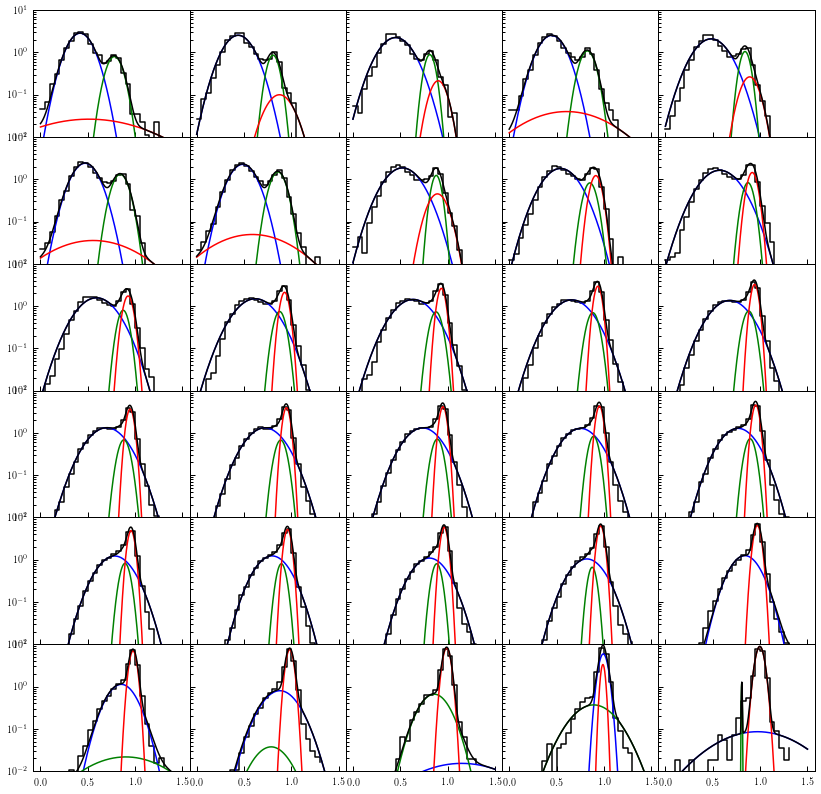

In [23]:
# row and column sharing
fig, axes = plt.subplots(6, 5, sharex=True, sharey=True, figsize=(14.0,14.0))
axes = axes.flatten()
plt.subplots_adjust(wspace=0, hspace=0)

N = len(mag_bins)-1
m1s = np.zeros(N)
m2s = np.zeros(N)
m3s = np.zeros(N)
s1s = np.zeros(N)
s2s = np.zeros(N)
s3s = np.zeros(N)
f1s = np.zeros(N)
f2s = np.zeros(N)
f3s = np.zeros(N)
for i in range(0,N):
    mask = (t['ABSMAG_r0.1']<mag_bins[i]) & (t['ABSMAG_r0.1']>mag_bins[i+1])
    N = np.sum(mask)
    
    # initial params
    f1 = 0.45
    m1 = color_model.lt_mean_color(mag_bin_centers[i])
    s1 = 0.4
    
    f3 = 0.45
    m3 = color_model.et_mean_color(mag_bin_centers[i])
    s3 = 0.2
    
    f2 = 0.1
    m2 = 0.8
    s2 = 0.2
    
    gmm = GaussianMixture(n_components=3, covariance_type='spherical',tol=10**-4,
                      means_init=[[m1],[m2],[m3]], weights_init=[f1,f2,f3],
                      precisions_init=[1.0/s1**2, 1.0/s2**2, 1.0/s3**2])
    
    X = color[mask]
    X = X.reshape((N,1))
    res = gmm.fit(X)
    m1, m2, m3 = res.means_
    s1, s2, s3 = np.sqrt((res.covariances_[0], res.covariances_[1], res.covariances_[2]))
    f1, f2, f3 = (res.weights_[0], res.weights_[1], res.weights_[2])
    
    m1s[i] = m1
    m2s[i] = m2
    m3s[i] = m3
    s1s[i] = np.sqrt(s1)
    s2s[i] = np.sqrt(s2)
    s3s[i] = np.sqrt(s3)
    f1s[i] = f1
    f2s[i] = f2
    f3s[i] = f3
    
    counts = np.histogram(color[mask], bins=color_bins)[0]
    counts = 1.0*counts/np.sum(counts)/np.diff(color_bins)
    ax = axes[i]
    ax.step(color_bins[:-1], counts, where='post', color='black')
    
    ax.plot(xsample, f1*norm.pdf(xsample, loc=m1, scale=s1), color='blue')
    ax.plot(xsample, f2*norm.pdf(xsample, loc=m2, scale=s2), color='green')
    ax.plot(xsample, f3*norm.pdf(xsample, loc=m3, scale=s3), color='red')
    y = f1*norm.pdf(xsample, loc=m1, scale=s1) +\
        f2*norm.pdf(xsample, loc=m2, scale=s2) +\
        f3*norm.pdf(xsample, loc=m3, scale=s3)
    ax.plot(xsample, y, color='black')
    
    print(i, N, res.converged_)
    
ax.set_yscale('log')
ax.set_ylim([0.01,10])
plt.show()

(-17, -24)

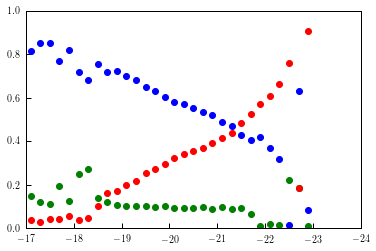

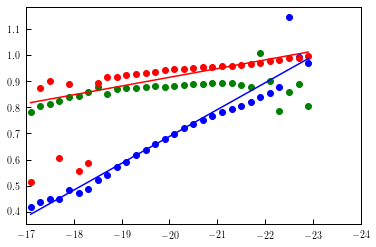

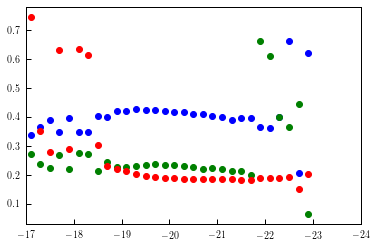

In [34]:
color_model = GalaxyColor()
color_model.params['color_m1'] = -0.10301207163024402
color_model.params['color_b1'] = -1.371778653581658

color_model.params['color_m2'] = -0.033475839944698944
color_model.params['color_b2'] = 0.24608502181357306

plt.figure()
plt.plot(mag_bin_centers, f1s, 'o', color='blue')
plt.plot(mag_bin_centers, f2s, 'o', color='green')
plt.plot(mag_bin_centers, f3s, 'o', color='red')
plt.ylim([0,1])
plt.xlim([-17,-24])

plt.figure()
plt.plot(mag_bin_centers, m1s, 'o', color='blue')
plt.plot(mag_bin_centers, m2s, 'o', color='green')
plt.plot(mag_bin_centers, m3s, 'o', color='red')

plt.plot(mag_bin_centers, color_model.lt_mean_color(mag_bin_centers), '-', color='blue')
plt.plot(mag_bin_centers, color_model.et_mean_color(mag_bin_centers), '-', color='red')

plt.xlim([-17,-24])

plt.figure()
plt.plot(mag_bin_centers, s1s, 'o', color='blue')
plt.plot(mag_bin_centers, s2s, 'o', color='green')
plt.plot(mag_bin_centers, s3s, 'o', color='red')
plt.xlim([-17,-24])

# fit full model

In [17]:
from galaxy_shapes.shape_models.color_model_components import GalaxyColor, blue_fraction
color_model = GalaxyColor() 
color_model.params['color_b1'] = -1.37177 - 0.1
color_model.params['color_s1'] = 0.4**2

N = int(10**7)
min_mag = -24
max_mag = -17
mag = np.random.random(N)*(max_mag-min_mag) + min_mag

c_et = color_model.et_rvs_color(mag[:N//2])
c_lt = color_model.lt_rvs_color(mag[N//2:])
color_model = np.hstack((c_et,c_lt))

w = np.zeros(N)
w[N//2:] = blue_fraction(mag[N//2:], m0=-21.25, s=1.5)
w[:N//2] = 1.0-blue_fraction(mag[:N//2], m0=-21.25, s=1.5)

In [11]:
from lss_observations.luminosity_functions import Blanton_2003_phi

phi = Blanton_2003_phi()

In [12]:
w = w*phi(mag)

In [13]:
# extinction model
from galaxy_shapes.shape_models.extinction_model_components import Shao07DustExtinction
extinction_model = Shao07DustExtinction()

costheta = np.random.random(N)
theta = np.arccos(costheta)
result = extinction_model.extinction_model(theta)
delta_g = result[:,1]
delta_r = result[:,2]
d_color = (delta_g-delta_r)

color_model_1 = 1.0*color_model
color_model_2 = 1.0*color_model
color_model_2[N//2:] = color_model[N//2:] + d_color[N//2:]

#mag = mag + result[:,2]

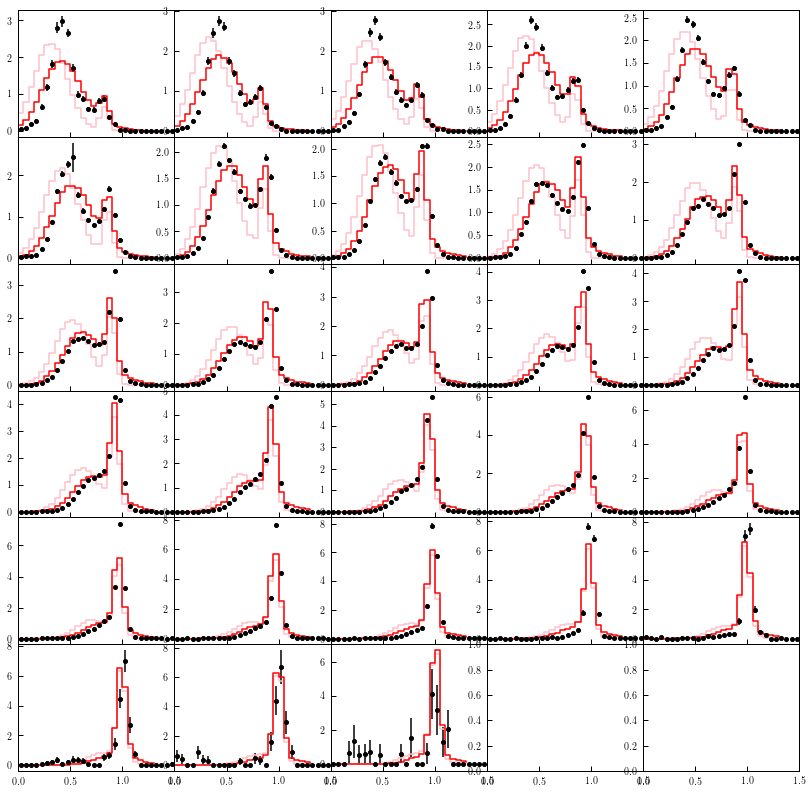

In [16]:
mag_bins = np.arange(-23,-17,0.2)[::-1]
mag_bin_centers = (mag_bins[:-1]+mag_bins[1:])/2.0
color_bins = np.arange(0,1.4,0.05)

# row and column sharing
fig, axes = plt.subplots(6, 5, sharex=True, sharey=False, figsize=(14.0,14.0))
axes = axes.flatten()
plt.subplots_adjust(wspace=0, hspace=0)

N = len(mag_bins)-1
for i in range(0,28):
    
    # model
    mask = (mag<mag_bins[i]) & (mag>mag_bins[i+1])
    N = np.sum(mask)
    
    counts = np.histogram(color_model_1[mask], bins=color_bins, weights=w[mask])[0]
    counts = 1.0*counts/np.sum(counts)/np.diff(color_bins)
    ax = axes[i]
    ax.step(color_bins[:-1], counts, where='post', color='pink')
    
    counts = np.histogram(color_model_2[mask], bins=color_bins, weights=w[mask])[0]
    counts = 1.0*counts/np.sum(counts)/np.diff(color_bins)
    ax = axes[i]
    ax.step(color_bins[:-1], counts, where='post', color='red')
    
    # observations
    t = Table.read('../data/sample_'+str(int(i))+'_g_minus_r.dat', format='ascii')
    x0 = t['g_minus_r']
    y0 = t['frequency']
    y0_err = t['err']
    ax.errorbar(x0,y0,y0_err,fmt='o', ms=4, color='black')
    
ax.set_xlim([0,1.5])

#ax.set_yscale('log')
#ax.set_ylim([0.05,5])

#fig.savefig('/Users/duncan/Desktop/test_2.pdf', dpi=250)

plt.show()

In [30]:
color_model = GalaxyColor() 
color_model.params['color_b1'] = -1.37177 - 0.1
color_model.params['color_s1'] = 0.4**2

for i in range(0,28):
    m = mag_bin_centers[i]
    f = blue_fraction(m, m0=-21.25, s=1.5)
    print("{0}, {1}, {2}, {3}, {4}, {5}".format(i+1, color_model.lt_mean_color(m), color_model.lt_scatter_color(m),
          color_model.et_mean_color(m), color_model.et_scatter_color(m),
          f))

1, 0.310303, 0.16, 0.825116, 0.04, 0.932976288927
2, 0.330905, 0.16, 0.83181, 0.04, 0.924141819979
3, 0.351507, 0.16, 0.838504, 0.04, 0.914249897746
4, 0.372109, 0.16, 0.845198, 0.04, 0.903203174946
5, 0.392711, 0.16, 0.851892, 0.04, 0.890903178804
6, 0.413313, 0.16, 0.858586, 0.04, 0.87725262946
7, 0.433915, 0.16, 0.86528, 0.04, 0.862158343035
8, 0.454517, 0.16, 0.871974, 0.04, 0.845534734916
9, 0.475119, 0.16, 0.878668, 0.04, 0.827307895917
10, 0.495721, 0.16, 0.885362, 0.04, 0.807420156451
11, 0.516323, 0.16, 0.892056, 0.04, 0.785834983043
12, 0.536925, 0.16, 0.89875, 0.04, 0.762541971656
13, 0.557527, 0.16, 0.905444, 0.04, 0.737561621488
14, 0.578129, 0.16, 0.912138, 0.04, 0.710949502625
15, 0.598731, 0.16, 0.918832, 0.04, 0.682799386093
16, 0.619333, 0.16, 0.925526, 0.04, 0.653244900718
17, 0.639935, 0.16, 0.93222, 0.04, 0.622459331202
18, 0.660537, 0.16, 0.938914, 0.04, 0.590653282701
19, 0.681139, 0.16, 0.945608, 0.04, 0.558070105874
20, 0.701741, 0.16, 0.952302, 0.04, 0.5249791